In [2]:
import seaborn as sns

sns.set_theme(
    palette="viridis",
    style="whitegrid"
)

In [3]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer

# Load the event logs
domestic_log = xes_importer.apply('Data/DomesticDeclarations.xes')
international_log = xes_importer.apply('Data/InternationalDeclarations.xes')

# Print the summary of the logs to understand the structure
domestic_summary = pm4py.get_event_attributes(domestic_log)
international_summary = pm4py.get_event_attributes(international_log)

domestic_summary, international_summary


parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

(['org:role', 'time:timestamp', 'concept:name', 'org:resource', 'id'],
 ['org:role', 'time:timestamp', 'concept:name', 'org:resource', 'id'])

In [4]:
import pandas as pd
from pm4py.statistics.traces.generic.log import case_statistics

# Get the unique activities
domestic_activities = set(event["concept:name"] for trace in domestic_log for event in trace)
international_activities = set(event["concept:name"] for trace in international_log for event in trace)

# Get the number of cases
domestic_case_count = len(domestic_log)
international_case_count = len(international_log)

# Get case durations (cycle times)
domestic_case_durations = case_statistics.get_all_case_durations(domestic_log, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})
international_case_durations = case_statistics.get_all_case_durations(international_log, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})

# Convert durations to DataFrame for easier analysis
domestic_durations_df = pd.DataFrame(domestic_case_durations)
international_durations_df = pd.DataFrame(international_case_durations)

# Can you think of useful KPIs for the processes?

Für die Analyse der Inlands- und Auslandsabrechnungsprozesse an der TU/e werden klare Ziele und Erfolgsfaktoren definiert. Diese dienen als Grundlage für die Identifizierung relevanter KPIs (Key Performance Indicators), mit denen sich die Prozessleistung messen und verbessern lässt.

Sowohl im Inlands- als auch im Auslandsabrechnungsprozess liegt der Fokus auf **Effizienz**, **Genauigkeit**, **Compliance** und **Kosteneffizienz**. Um diese Ziele zu erreichen, werden folgende KPIs überwacht:

- **Durchlaufzeit**: Die Zeitspanne von der Einreichung bis zur finalen Zahlung bzw. Genehmigung. Dieser KPI ist ein zentraler Indikator für die Effizienz und Pünktlichkeit beider Prozesse.
  
- **Genehmigungszeiten**: Die Zeit, die in den verschiedenen Genehmigungsstufen benötigt wird. Sie hilft, Engpässe zu identifizieren und Verzögerungen zu vermeiden, die besonders im Auslandsabrechnungsprozess erhebliche Auswirkungen haben können.
  
- **Ablehnungsquote**: Der Anteil der abgelehnten Abrechnungen in den Genehmigungsstufen. Diese Metrik gibt Aufschluss über die Genauigkeit der eingereichten Abrechnungen und deren Einhaltung von Richtlinien.

- **Durchsatz**: Die Anzahl der monatlich abgeschlossenen Fälle, die Auskunft über die Leistungsfähigkeit und Effizienz des Prozesses geben.

- **Dauer der Nachbearbeitung**: Spezifisch für den Auslandsprozess, zeigt dieser KPI, wie lange es dauert, abgelehnte Anträge zu korrigieren und erneut einzureichen. Dies beeinflusst direkt die Pünktlichkeit und Kosteneffizienz.

## **Durchlaufzeit (Cycle Time)**

Die **Durchlaufzeit** misst die Zeitspanne von der Einreichung einer Abrechnung bis zur finalen Zahlung. Eine kurze Durchlaufzeit ist entscheidend für die Effizienz des Prozesses. Dieser KPI hilft uns zu verstehen, wie lange der gesamte Prozess durchschnittlich dauert und ob es dabei signifikante Abweichungen gibt.

### **Mathematische Definition:**

Die Durchlaufzeit $\text{Cycle Time}$ für eine Abrechnung $i$ wird berechnet als die Differenz zwischen dem Zeitpunkt der Einreichung $t_{\text{Einreichung}, i}$ und dem Zeitpunkt der Zahlung $t_{\text{Zahlung}, i}$:

$$
\text{Cycle Time}_i = t_{\text{Zahlung}, i} - t_{\text{Einreichung}, i}
$$

Für den KPI betrachten wir die durchschnittliche Durchlaufzeit über alle Abrechnungen:

$$
\text{Durchschnittliche Cycle Time} = \frac{1}{N} \sum_{i=1}^{N} \text{Cycle Time}_i
$$

Dabei ist $N$ die Gesamtzahl der Abrechnungen.

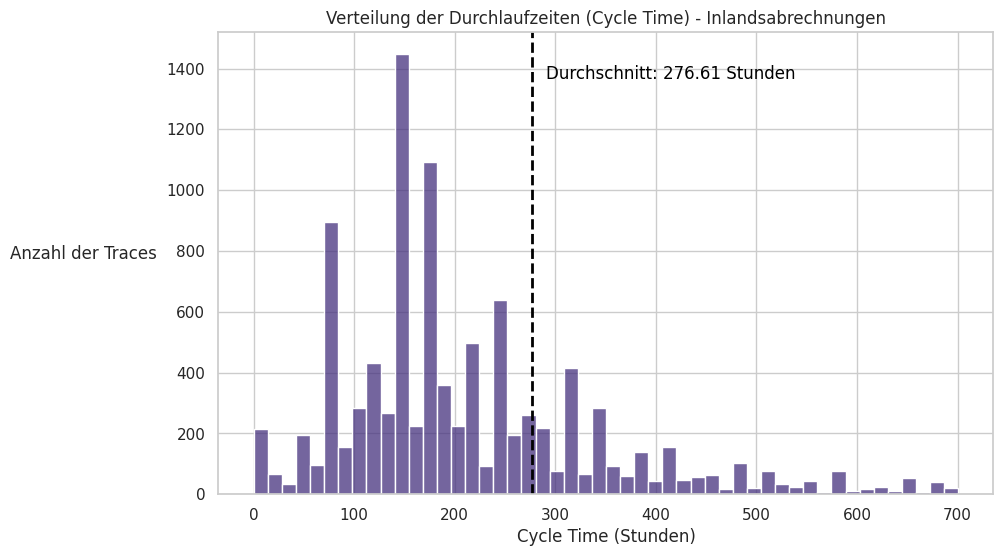

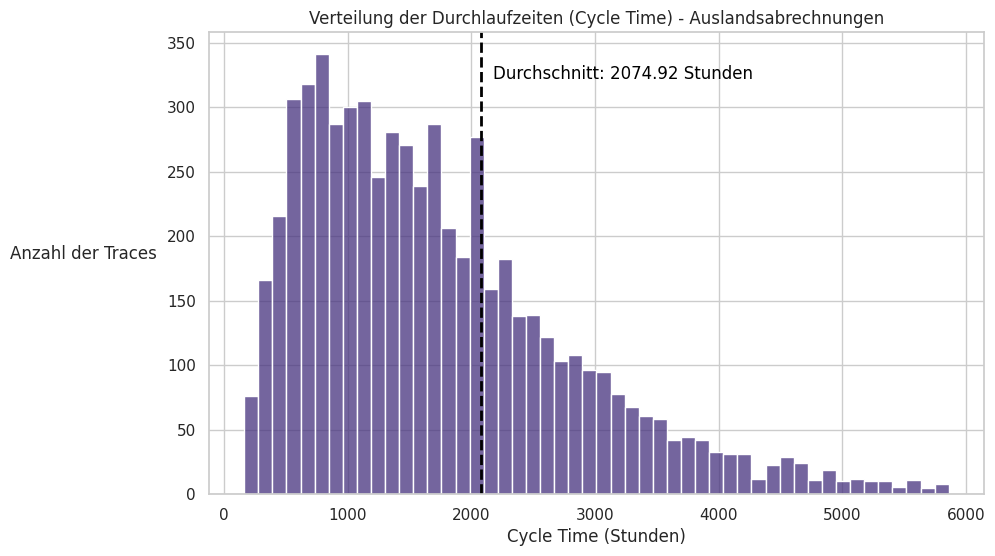

(276.61323227513225, 2074.9211875656865)

In [5]:
import pm4py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pm4py.statistics.traces.generic.log import case_statistics

def plot_cycle_time(log, title) -> float:
    """
    Berechnet und visualisiert die Durchlaufzeit (Cycle Time) eines Prozesses.

    Parameters:
    log: pm4py.objects.log.obj.EventLog
        Das Event-Log des Prozesses.
    title: str
        Der Titel für den Plot.
    """
    # Berechnung der Durchlaufzeit für jede Abrechnung
    case_durations = case_statistics.get_all_case_durations(log, parameters={
        case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
    })

    # Umwandlung in DataFrame für die Analyse
    durations_df = pd.DataFrame(case_durations, columns=['Cycle Time'])

    # Konvertierung der Durchlaufzeit von Sekunden in Stunden
    durations_df['Cycle Time (Hours)'] = durations_df['Cycle Time'] / 3600

    # Berechnung der durchschnittlichen Durchlaufzeit in Stunden
    average_cycle_time_hours = durations_df['Cycle Time (Hours)'].mean()

    # Beschränkung der Darstellung auf die 95. Perzentile zur Reduktion von Ausreißern
    upper_limit_hours = durations_df['Cycle Time (Hours)'].quantile(0.95)
    filtered_durations = durations_df[durations_df['Cycle Time (Hours)'] <= upper_limit_hours]

    # Plotten der Verteilung der Durchlaufzeiten in Stunden mit Seaborn
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_durations['Cycle Time (Hours)'], bins=50, kde=False)
    plt.axvline(average_cycle_time_hours, color='black', linestyle='dashed', linewidth=2)
    plt.text(
        average_cycle_time_hours + average_cycle_time_hours*0.05, # mit offset, damit der Te
        plt.ylim()[1] * 0.9, 
        f'Durchschnitt: {average_cycle_time_hours:.2f} Stunden',
        color='black'
        )
    plt.title(f'Verteilung der Durchlaufzeiten (Cycle Time) - {title}')
    plt.xlabel('Cycle Time (Stunden)')
    plt.ylabel('Anzahl der Traces', rotation=0, labelpad=60)
    plt.show()

    return average_cycle_time_hours

# Nutzung der Funktion für Inlandsabrechnungen
average_domestic_cycle_time = plot_cycle_time(domestic_log, 'Inlandsabrechnungen')

# Nutzung der Funktion für Auslandsabrechnungen
average_international_cycle_time = plot_cycle_time(international_log, 'Auslandsabrechnungen')

# Ausgabe der durchschnittlichen Durchlaufzeiten
average_domestic_cycle_time, average_international_cycle_time


## **Ablehnungsquote (Rejection Rate)**

Die **Ablehnungsquote** gibt an, wie häufig Abrechnungen in den verschiedenen Phasen des Inlandsabrechnungsprozesses abgelehnt werden. Eine hohe Ablehnungsquote kann auf Probleme in der Qualität der eingereichten Anträge oder auf ineffiziente Genehmigungsprozesse hinweisen. Dieser KPI ist entscheidend für die Verbesserung der Genauigkeit und Compliance im Prozess.

### **Mathematische Definition:**

Die Ablehnungsquote $\text{Rejection Rate}$ in einer Phase $j$ wird berechnet als das Verhältnis der abgelehnten Abrechnungen $R_j$ zur Gesamtzahl der in diese Phase eingetretenen Abrechnungen $N_j$:

$$
\text{Rejection Rate}_j = \frac{R_j}{N_j} \times 100\%
$$

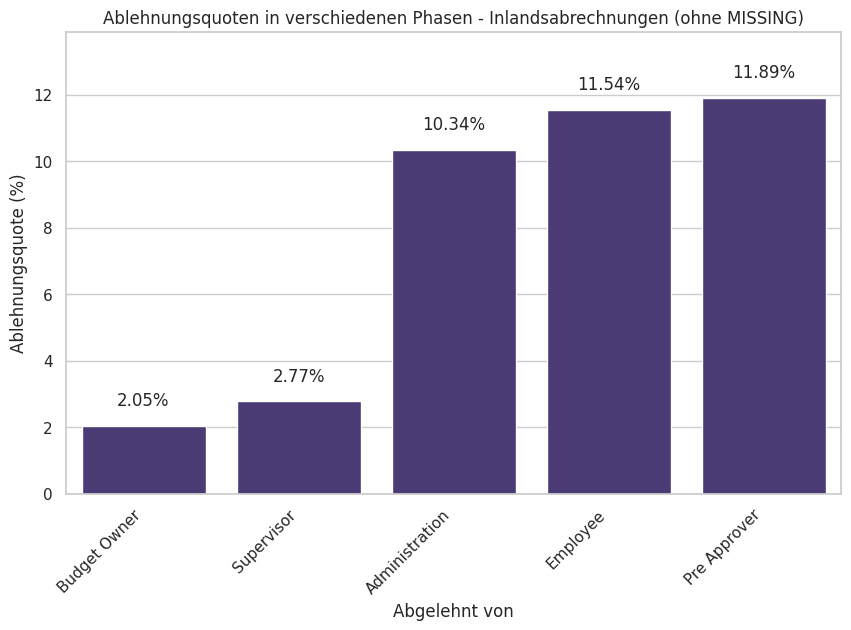

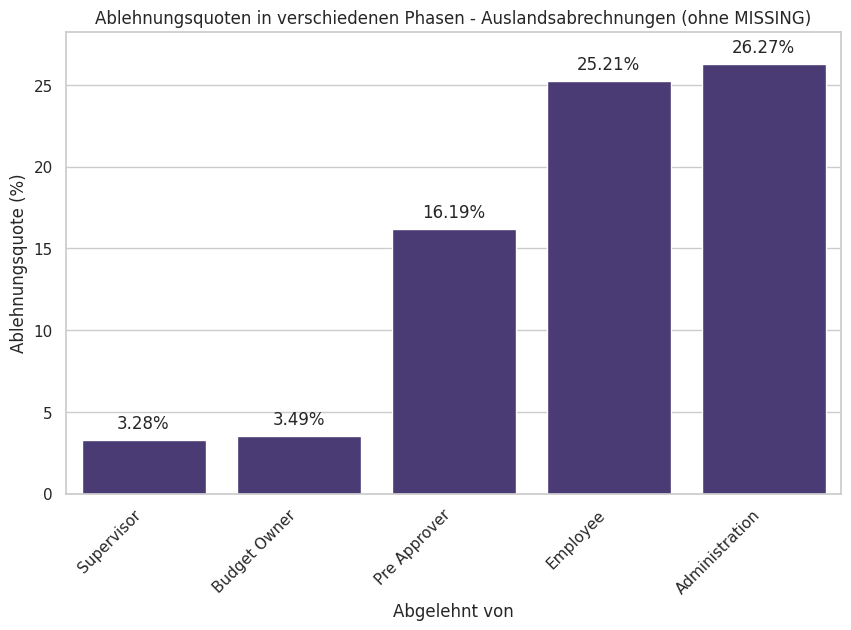

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_rejection_rate(log, phase):
    """
    Berechnet die Ablehnungsquote für eine spezifische Phase im Prozess.

    Parameters:
    log: pm4py.objects.log.obj.EventLog
        Das Event-Log des Prozesses.
    phase: str
        Der Name der Phase, für die die Ablehnungsquote berechnet werden soll.

    Returns:
    float
        Die Ablehnungsquote in Prozent.
    """
    total_cases_in_phase = 0
    rejected_cases_in_phase = 0
    for trace in log:
        phase_found = False
        rejected_in_this_phase = False
        for event in trace:
            if phase in event["concept:name"]:
                phase_found = True
            if phase in event["concept:name"] and "REJECTED" in event["concept:name"]:
                rejected_in_this_phase = True
        if phase_found:
            total_cases_in_phase += 1
            if rejected_in_this_phase:
                rejected_cases_in_phase += 1
    
    return (rejected_cases_in_phase / total_cases_in_phase) * 100 if total_cases_in_phase > 0 else 0

def plot_rejection_rates(log, phases, title):
    """
    Berechnet und visualisiert die Ablehnungsquoten für verschiedene Phasen im Prozess.

    Parameters:
    log: pm4py.objects.log.obj.EventLog
        Das Event-Log des Prozesses.
    phases: list of str
        Die Liste der Phasen, für die die Ablehnungsquoten berechnet werden sollen.
    title: str
        Der Titel für den Plot.
    """
    # Berechnung der Ablehnungsquoten für jede Phase
    rejection_rates = {phase.title().replace("_", " "): calculate_rejection_rate(log, phase) for phase in phases}

    # Umwandlung der Daten in ein DataFrame und Sortierung nach Ablehnungsquote (aufsteigend)
    rejection_rates_df = pd.DataFrame(list(rejection_rates.items()), columns=['Phase', 'Rejection Rate'])
    rejection_rates_df = rejection_rates_df.sort_values(by='Rejection Rate', ascending=True).reset_index(drop=True)

    # Plot der Ablehnungsquoten mit Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Phase', y='Rejection Rate', data=rejection_rates_df, order=rejection_rates_df['Phase'])

    # Titel und Achsenbeschriftungen
    plt.title(title)
    plt.xlabel('Abgelehnt von')
    plt.ylabel('Ablehnungsquote (%)')

    # Prozentwerte über den Balken anzeigen und mit den Balken verschieben
    for index, row in rejection_rates_df.iterrows():
        plt.text(index, row['Rejection Rate'] + 0.5, f"{row['Rejection Rate']:.2f}%", ha='center', va='bottom')

    # Rotieren der x-Achsen-Beschriftungen
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, max(rejection_rates_df['Rejection Rate']) + 2)  # Anpassung des Y-Limits

    plt.show()

# Phasen ohne MISSING-Phase
phases = [
    "SUPERVISOR", 
    "BUDGET OWNER", 
    "ADMINISTRATION", 
    "EMPLOYEE", 
    "PRE_APPROVER"
]

# Nutzung der Funktion für Inlandsabrechnungen
plot_rejection_rates(domestic_log, phases, 'Ablehnungsquoten in verschiedenen Phasen - Inlandsabrechnungen (ohne MISSING)')

# Nutzung der Funktion für Auslandsabrechnungen
plot_rejection_rates(international_log, phases, 'Ablehnungsquoten in verschiedenen Phasen - Auslandsabrechnungen (ohne MISSING)')


Die Grafiken zeigen die Ablehnungsquoten in den verschiedenen Phasen der Inlands- und Auslandsabrechnungsprozesse. Diese Metrik ist ein wichtiger KPI, da sie direkt Aufschluss über die Qualität der eingereichten Anträge und die Strenge der Prüfung in den jeweiligen Phasen gibt.

In beiden Prozessen fallen die höchsten Ablehnungsquoten in den Phasen "Pre Approver", "Employee" und "Administration" auf. Besonders bei den Auslandsabrechnungen ist die Ablehnungsquote in der "Administration" mit 26,27% am höchsten, gefolgt von "Employee" (25,21%) und "Pre Approver" (16,19%). Diese hohen Quoten weisen auf potenzielle Engpässe oder Problemstellen hin, die die Effizienz und die Pünktlichkeit des Prozesses negativ beeinflussen können. Deshalb ist die Ablehnungsquote eine gute KPI, um diese Phasen gezielt zu überwachen und Verbesserungspotenziale zu identifizieren.

Im Vergleich dazu sind die Ablehnungsquoten in den Phasen "Supervisor" und "Budget Owner" bei beiden Prozessen deutlich niedriger. Dies könnte darauf hinweisen, dass in diesen Phasen weniger strenge Prüfungen stattfinden oder dass die Qualität der eingereichten Anträge hier besser ist. Auch diese Informationen sind wertvoll, um den gesamten Prozess besser zu verstehen und gezielt zu optimieren.

## **Durchsatz (Throughput)**

Der **Durchsatz** misst die Anzahl der Abrechnungen, die innerhalb eines bestimmten Zeitraums abgeschlossen werden. Dieser KPI hilft uns zu verstehen, wie effizient der Prozess insgesamt arbeitet und ob es Perioden mit höherer oder niedrigerer Bearbeitungsrate gibt.

### **Mathematische Definition:**

Der Durchsatz $\text{Throughput}$ wird als die Anzahl der abgeschlossenen Fälle $C(t)$ in einem bestimmten Zeitraum $T$ berechnet:

$$
\text{Throughput} = \frac{C(t)}{T}
$$

Dabei kann $T$ ein Monat, ein Quartal oder ein anderes Zeitintervall sein, das für die Analyse relevant ist.


/tmp/ipykernel_14170/1251526459.py:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  case_end_times_df['Month'] = case_end_times_df['End Time'].dt.to_period('M')


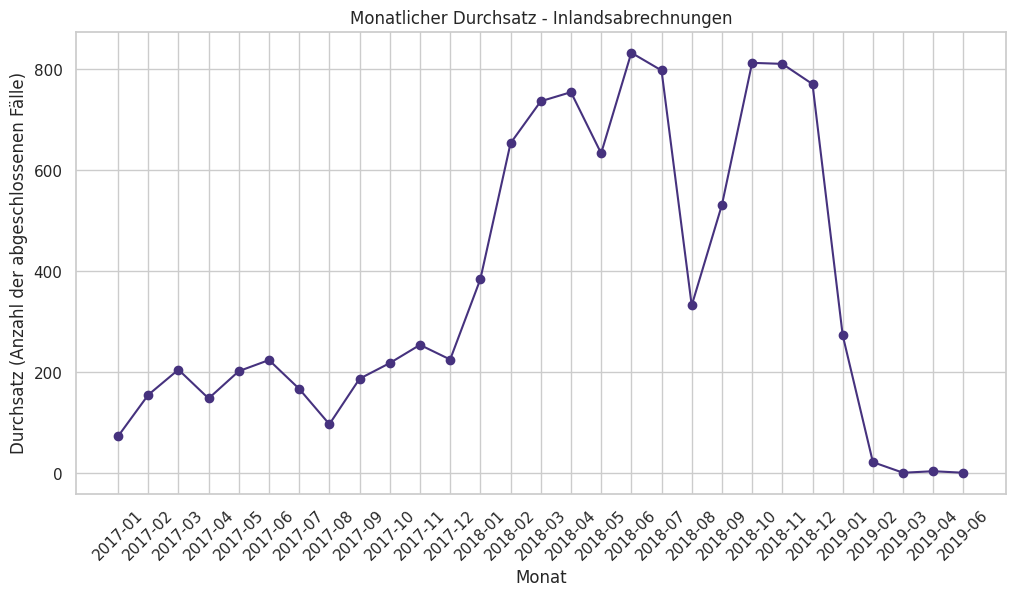

/tmp/ipykernel_14170/1251526459.py:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  case_end_times_df['Month'] = case_end_times_df['End Time'].dt.to_period('M')


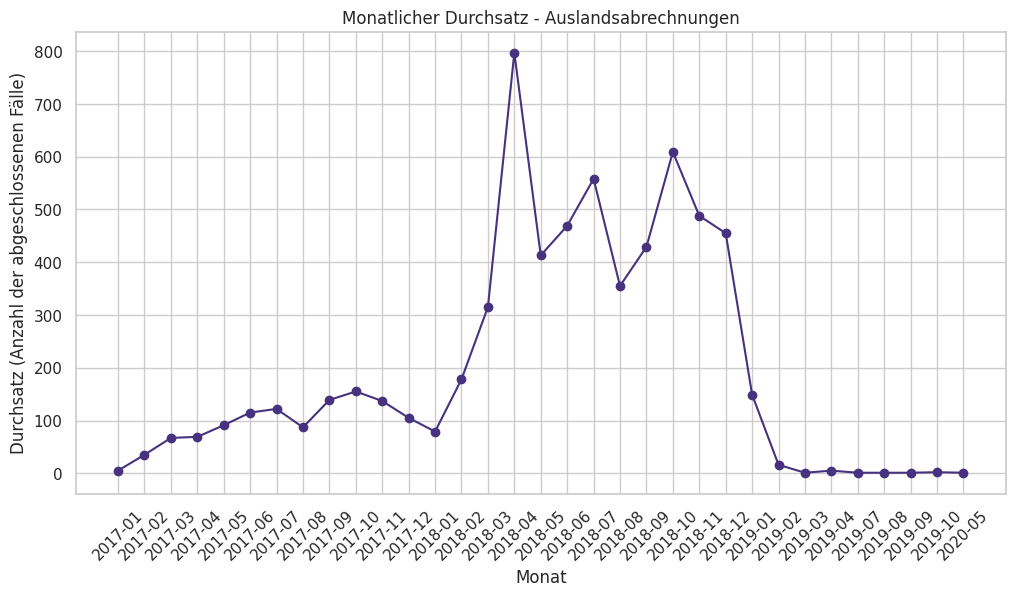

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_throughput(log):
    """
    Berechnet den monatlichen Durchsatz (Anzahl abgeschlossener Fälle) für ein gegebenes Event-Log.

    Parameters:
    log: pm4py.objects.log.obj.EventLog
        Das Event-Log des Prozesses.

    Returns:
    pd.DataFrame
        Ein DataFrame, das den monatlichen Durchsatz enthält.
    """
    # Extrahiere Abschlusszeiten der Fälle
    case_end_times = []
    for trace in log:
        case_end_time = max(event["time:timestamp"] for event in trace)
        case_end_times.append(case_end_time)

    # Erstelle DataFrame für Abschlusszeiten
    case_end_times_df = pd.DataFrame(case_end_times, columns=['End Time'])

    # Füge eine Spalte für den Monat hinzu
    case_end_times_df['Month'] = case_end_times_df['End Time'].dt.to_period('M')

    # Berechne den monatlichen Durchsatz (Anzahl abgeschlossener Fälle pro Monat)
    throughput_df = case_end_times_df.groupby('Month').size().reset_index(name='Throughput')

    return throughput_df

def plot_throughput(throughput_df, title):
    """
    Visualisiert den monatlichen Durchsatz für ein gegebenes DataFrame.

    Parameters:
    throughput_df: pd.DataFrame
        Ein DataFrame, das den monatlichen Durchsatz enthält.
    title: str
        Der Titel für den Plot.
    """
    # Plot des monatlichen Durchsatzes
    plt.figure(figsize=(12, 6))
    plt.plot(throughput_df['Month'].astype(str), throughput_df['Throughput'], marker='o')
    plt.title(title)
    plt.xlabel('Monat')
    plt.ylabel('Durchsatz (Anzahl der abgeschlossenen Fälle)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Nutzung der Funktionen für Inlandsabrechnungen
domestic_throughput_df = calculate_throughput(domestic_log)
plot_throughput(domestic_throughput_df, 'Monatlicher Durchsatz - Inlandsabrechnungen')

# Nutzung der Funktionen für Auslandsabrechnungen
international_throughput_df = calculate_throughput(international_log)
plot_throughput(international_throughput_df, 'Monatlicher Durchsatz - Auslandsabrechnungen')


Die Grafiken zeigen den monatlichen Durchsatz sowohl für den Inlands- als auch den Auslandsabrechnungsprozess. Der Durchsatz als KPI bietet wertvolle Einblicke in die Effizienz und Kapazität der Prozesse über die Zeit hinweg.

In beiden Prozessen ist eine deutliche Steigerung des Durchsatzes im Jahr 2018 erkennbar. Diese Zunahme der abgeschlossenen Fälle, insbesondere mit Spitzenwerten im Juni und Oktober, könnte auf eine Phase erhöhter Aktivität oder Änderungen im Prozess hinweisen. Ab Januar 2019 fällt der Durchsatz jedoch dramatisch ab, was möglicherweise durch eine Verringerung der Abrechnungsaktivität, saisonale Schwankungen oder andere externe Faktoren verursacht wurde.

Diese Entwicklungen verdeutlichen die Bedeutung des Durchsatzes als KPI, um Trends und potenzielle Engpässe zu identifizieren, die einer tiefergehenden Analyse bedürfen, um die Prozesseffizienz weiter zu optimieren.